In [190]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage
from scipy import fftpack

In [191]:
image_file = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')
image_file.info()
type(image_file)

Filename: C:\Users\rehg98\.astropy\cache\download\py3\1c6f961384c074b1b25de6c1f4fd2344
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   (2048, 2048)   float32   


astropy.io.fits.hdu.hdulist.HDUList

In [192]:
image_data = image_file[0].data
image_data = image_data.astype(float)
print(image_data)

[[ 0.28772882  0.31463188  0.31120118 ..., -0.26744589 -0.26138833
  -0.19891326]
 [ 0.23843557  0.26356095  0.27608296 ..., -0.10312956 -0.11086034
  -0.06235358]
 [ 0.32085782  0.3036944   0.35584533 ..., -0.12078809 -0.05707451
  -0.07544205]
 ..., 
 [ 0.30768567  0.30357176  0.30380633 ..., -0.19853105 -0.15406299
  -0.17564408]
 [ 0.16823567  0.13827965  0.25008214 ..., -0.21506804 -0.12519895
  -0.26080811]
 [ 0.19998959  0.20467333  0.2182963  ..., -0.25283489 -0.12982941
  -0.30584782]]


In [193]:
F = fftpack.fftshift(fftpack.fft2(image_data))
psd2D = np.abs(F)**2

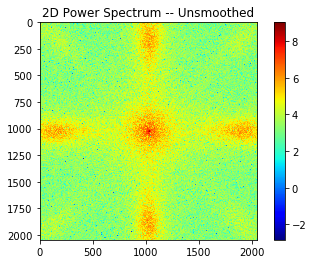

In [194]:
plt.imshow(np.log10(psd2D), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Unsmoothed")
plt.colorbar()
plt.show()

In [259]:
smooth_data = scipy.ndimage.filters.gaussian_filter(image_data, 9.75)
F_smooth = fftpack.fftshift(fftpack.fft2(smooth_data))
psd2D_smooth = np.abs(F_smooth)**2

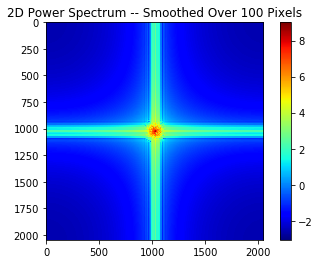

In [196]:
plt.imshow(np.log10(psd2D_smooth), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Smoothed Over 100 Pixels")
plt.colorbar()
plt.show()

In [261]:
def power1D(image, num_bins):
    #help from Jessica Lu's radialProfile module (http://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles)
    y, x = np.indices(image.shape)
    center = np.array([(x.max() - x.min()) / 2., (x.max() - x.min()) / 2.])
    
    if image.shape[0]%2 == 0:
        center+=0.5
    
    radii = np.hypot(x - center[0], y - center[1])
    
    sorted_radii_indices = np.argsort(radii.flat)
    sorted_radii = radii.flat[sorted_radii_indices]
    sorted_pixels = image.flat[sorted_radii_indices]

    
    #bins = np.linspace(1.0, image.shape[0] / 2., num_bins + 1)
    
    bins = np.logspace(0, np.log10(image.shape[0]/2.), num_bins + 1)
    #print(bins)
    #bins = np.append([0], bins)
    
    bin_weights = np.histogram(sorted_radii, bins)[0]
    #print(bin_weights)
    bin_edges = np.cumsum(bin_weights)
    pixel_sums = np.cumsum(sorted_pixels, dtype=float)
    #bin_totals = pixel_sums[bin_edges[1:] - 1] - pixel_sums[bin_edges[:-1] - 1]
    bin_totals = pixel_sums[bin_edges[1:] - 1] - pixel_sums[bin_edges[:-1] - 1]
    radial_prof = bin_totals/bin_weights[1:]
    
    #print(radial_prof)
    #print(bins[1:-1].size, radial_prof.size)
    
    return bins[1:], radial_prof

In [257]:
def PowerSpectrum(psd2D, sizedeg = 12.25, size = 2048, bins=50):#edges should be pixels
    
    ell_arr, psd1D = power1D(psd2D, num_bins = 50)
    edge2center = lambda x: x[:-1]+0.5*(x[1:]-x[:-1])
    print(ell_arr.size)
    ell_arr = edge2center(ell_arr)
    print(ell_arr.size)
    
    ell_arr *= 360./np.sqrt(sizedeg)
    norm = ((2*np.pi*np.sqrt(sizedeg)/360.0)**2)/(size**2)**2
    powspec = ell_arr*(ell_arr+1)/(2*np.pi) * norm * psd1D
    return ell_arr, powspec

C:\Users\rehg98\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


50
49


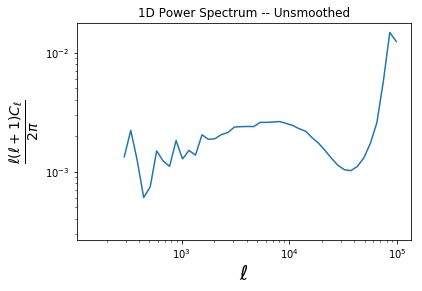

In [263]:
ell, powspec = PowerSpectrum(psd2D)

plt.loglog(ell, powspec)  
plt.title('1D Power Spectrum -- Unsmoothed')
plt.xlabel(r'$\ell$', fontsize = 20)
#plt.xlim(100, 3000)
plt.ylabel(r'$\frac{\ell (\ell + 1) C_\ell}{2\pi}$', fontsize = 20)
plt.show()

C:\Users\rehg98\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


50
49


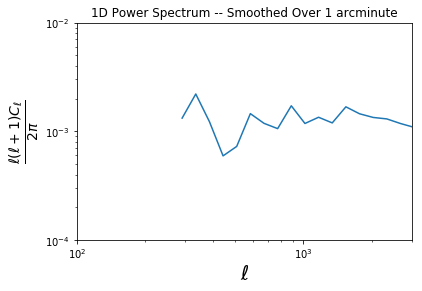

In [266]:
ell_smooth, powspec_smooth = PowerSpectrum(psd2D_smooth)

plt.loglog(ell_smooth, powspec_smooth)
plt.title('1D Power Spectrum -- Smoothed Over 1 arcminute')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.xlim(100, 3000)
plt.ylim(1e-4, 1e-2)
plt.ylabel(r'$\frac{\ell (\ell + 1) C_\ell}{2\pi}$', fontsize = 20)
plt.show()